# 0) chargement de spark

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# 1) lire de la donnée

## 1.1) lecture brute

In [2]:
path  = "./../data/Villes/ville_1.csv"
# lecture d'un fichier de manière la plus brute
df    = spark.read.load(path, format="csv")
df.dtypes

[('_c0', 'string'),
 ('_c1', 'string'),
 ('_c2', 'string'),
 ('_c3', 'string'),
 ('_c4', 'string'),
 ('_c5', 'string'),
 ('_c6', 'string'),
 ('_c7', 'string'),
 ('_c8', 'string'),
 ('_c9', 'string'),
 ('_c10', 'string'),
 ('_c11', 'string'),
 ('_c12', 'string')]

## 1.2) lecture avec les entêtes

In [3]:
# l'option 'header' permet de rajouter les noms des colonnes 
df = spark.read.format('csv').options(header=True).load(path)
df.dtypes

[('id', 'string'),
 ('vitesse_a_pied', 'string'),
 ('vitesse_a_velo', 'string'),
 ('home', 'string'),
 ('travail', 'string'),
 ('sportif', 'string'),
 ('casseur', 'string'),
 ('statut', 'string'),
 ('salaire', 'string'),
 ('sexe', 'string'),
 ('age', 'string'),
 ('sportivite', 'string'),
 ('velo_perf_minimale', 'string')]

## 1.3) lecture avec les types détectés automatiquement

In [4]:
# l'option 'inferSchema' permet de transformer les colonnes en 
# types plus précis : entier  / booléens / chaines de caractères...
# bien sûr spark trouve les types uniquement si le fichier d'origine
# permet de les trouver de manière simple
df = spark.read.format('csv').options(header=True, inferSchema=True).load(path)
df.dtypes

[('id', 'int'),
 ('vitesse_a_pied', 'double'),
 ('vitesse_a_velo', 'double'),
 ('home', 'string'),
 ('travail', 'string'),
 ('sportif', 'boolean'),
 ('casseur', 'boolean'),
 ('statut', 'string'),
 ('salaire', 'double'),
 ('sexe', 'string'),
 ('age', 'int'),
 ('sportivite', 'double'),
 ('velo_perf_minimale', 'double')]

## 1.4) lecture avec schéma

In [5]:
df.schema

StructType(List(StructField(id,IntegerType,true),StructField(vitesse_a_pied,DoubleType,true),StructField(vitesse_a_velo,DoubleType,true),StructField(home,StringType,true),StructField(travail,StringType,true),StructField(sportif,BooleanType,true),StructField(casseur,BooleanType,true),StructField(statut,StringType,true),StructField(salaire,DoubleType,true),StructField(sexe,StringType,true),StructField(age,IntegerType,true),StructField(sportivite,DoubleType,true),StructField(velo_perf_minimale,DoubleType,true)))

# 2) écriture de la dataframe sur le disque

## 2.1) choix du format : csv

In [6]:
df.write.format("csv").save("./../data/Villes/csv")

AnalysisException: 'path file:/home/jovyan/data/Villes/csv already exists.;'

## 2.2) choix du format : parquet

In [7]:
df.write.format("parquet").save("./../data/Villes/parquet")

AnalysisException: 'path file:/home/jovyan/data/Villes/parquet already exists.;'

In [8]:
df_parquet = spark.read.load("./../data/Villes/parquet", format="parquet")

## 2.3) choix du format : json

In [9]:
df.write.save("./../data/Villes/ville", format="json")

AnalysisException: 'path file:/home/jovyan/data/Villes/ville already exists.;'

In [10]:
!ls ./../data/Villes/ville/

part-00000-53f5c887-ffc7-4cf1-8910-3af67f1a4f39-c000.json  _SUCCESS


## 2.4) lecture de différents formats

In [11]:
spark.read.load("./../data/Villes/ville/", format="json")

DataFrame[age: string, casseur: string, home: string, id: string, salaire: string, sexe: string, sportif: string, sportivite: string, statut: string, travail: string, velo_perf_minimale: string, vitesse_a_pied: string, vitesse_a_velo: string]

In [12]:
spark.read.load("./../data/Cyclistes/", format="csv").count()

42105

# 3) Calculer des résultats : les actions 

## 3.1) nombre de lignes : count

In [13]:
df = spark.read.load("./../data/Cyclistes/", format="csv", header=True, inferSchema="True")
df.count()

42000

In [14]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- sur_velo: boolean (nullable = true)
 |-- velo: string (nullable = true)
 |-- vitesse: double (nullable = true)
 |-- position: string (nullable = true)
 |-- destination_finale: string (nullable = true)



## 3.2) moyenne : agg + colonne + mean

In [15]:
df.agg({"vitesse" : "mean"})

DataFrame[avg(vitesse): double]

## 3.3) quantile approximatifs pour gagner du temps de calcul

In [16]:
import time

In [17]:
def calcul_quantile(df, erreur_acceptee):
    debut            = time.time()
    colonne          = "vitesse"
    quantiles_voulus = [0.25, 0.50, 0.75]
    resultat         =  df.approxQuantile(colonne, quantiles_voulus , erreur_acceptee )
    fin              = time.time()
    delais           = fin -debut
    print ("delais =%.2f sec, quantiles = %s"%(delais, resultat))

In [18]:
calcul_quantile(df, 0.05)

delais =0.83 sec, quantiles = [0.3539158095373562, 0.7240554987509484, 1.1104489319259998]


In [19]:
calcul_quantile(df, 0.01)

delais =0.61 sec, quantiles = [0.2140675816428125, 0.6982868836514823, 1.1258871627308575]


In [20]:
calcul_quantile(df, 0)

delais =0.58 sec, quantiles = [0.23492321205533298, 0.6773387766132546, 1.1198635468743852]


## Reload de la dataframe

In [21]:
villes =spark.read.load("./../data/Villes/", format="csv", header=True, inferSchema="True")
villes.printSchema()

root
 |-- id: integer (nullable = true)
 |-- vitesse_a_pied: double (nullable = true)
 |-- vitesse_a_velo: double (nullable = true)
 |-- home: string (nullable = true)
 |-- travail: string (nullable = true)
 |-- sportif: boolean (nullable = true)
 |-- casseur: boolean (nullable = true)
 |-- statut: string (nullable = true)
 |-- salaire: double (nullable = true)
 |-- sexe: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- sportivite: double (nullable = true)
 |-- velo_perf_minimale: double (nullable = true)



## 3.4) corrélation

In [22]:
villes.corr("age", "vitesse_a_velo")

-0.11282023097307793

## 3.5) covariance

In [23]:
villes.cov("age", "vitesse_a_velo")

-3.31681635906206

## 3.6) sample

In [24]:
villes_1_pct = villes.sample(False, 0.01)
villes_1_pct.count()

2

In [25]:
villes.exceptAll(villes_1_pct).count()

103

## 3.7) filter 

In [26]:
villes.filter(villes.sexe=="F").count()

63

# 4) Transformer la données : les transformations!

## Transformations : demandent à être suivi par un collect ou une action (count par exemple)

## 4.1) obtenir des statistiques sur les colonnes numériques

In [27]:
villes.describe(["sexe", "age"]).describe().collect()

[Row(summary='count', summary='5', sexe='3', age='5'),
 Row(summary='mean', summary=None, sexe='105.0', age='54.41256919394815'),
 Row(summary='stddev', summary=None, sexe='NaN', age='39.028256496921905'),
 Row(summary='min', summary='count', sexe='105', age='105'),
 Row(summary='max', summary='stddev', sexe='H', age='83')]

## 4.2) groupby

In [28]:
villes.groupBy("sexe").agg({"sportivite" : "mean"}).collect()

[Row(sexe='F', avg(sportivite)=2.6586524340782742),
 Row(sexe='H', avg(sportivite)=1.740897061446013)]

In [29]:
villes.groupBy("sexe").agg({"sportivite" : "mean", "age":"max"}, ).collect()

[Row(sexe='F', avg(sportivite)=2.6586524340782742, max(age)=82),
 Row(sexe='H', avg(sportivite)=1.740897061446013, max(age)=83)]

## 4.3) summary 

In [30]:
villes.summary("count", "max").collect()

[Row(summary='count', id='105', vitesse_a_pied='105', vitesse_a_velo='105', home='105', travail='105', statut='105', salaire='105', sexe='105', age='105', sportivite='105', velo_perf_minimale='105'),
 Row(summary='max', id='105', vitesse_a_pied='4.183645670126603', vitesse_a_velo='10.459114175316511', home='(lon:9.44 lat:28.85)', travail='(lon:9.90 lat:37.43)', statut='technicien_de_surface', salaire='62319.743476583586', sexe='H', age='83', sportivite='6.97274278354434', velo_perf_minimale='7.37274278354434')]

## 4.4) union de dataframe

#### ajouter les colonnes les unes à côté des autres : join

In [31]:
villes.join(villes, on="id").describe()

DataFrame[summary: string, id: string, vitesse_a_pied: string, vitesse_a_velo: string, home: string, travail: string, statut: string, salaire: string, sexe: string, age: string, sportivite: string, velo_perf_minimale: string, vitesse_a_pied: string, vitesse_a_velo: string, home: string, travail: string, statut: string, salaire: string, sexe: string, age: string, sportivite: string, velo_perf_minimale: string]

#### ajouter les lignes les unes sous les autres : union

In [32]:
villes.unionByName(villes).count()

210

## 4.5) filtre

In [33]:
villes.where(villes.sexe=="F").count()

63

## 4.6) concaténation de colonne : F.concat

In [36]:
from pyspark.sql.types import *
from pyspark.sql       import functions as F

In [37]:
path       = "./../data/Cyclistes/*.csv" 
tous_les_cyclistes = spark.read.format("csv").option("header", "true").load(path, inferSchema=True)
tous_les_cyclistes.count()
tous_les_cyclistes.withColumn("id_sur_velo", F.concat(tous_les_cyclistes.id,  tous_les_cyclistes.sur_velo)).first()

Row(id=42, timestamp=1, sur_velo=False, velo='False', vitesse=0.02, position='(lon:18.76 lat:30.72)', destination_finale='(lon:34.80 lat:2.68)', id_sur_velo='42false')

# 5) udf 
Il est possible d'enregistrer des fonctions python que l'on écrit nous même pour les appliquer sur une colonne d'une dataframe, c'est ce qu'on appelle les udf, pour User Defined Functions

In [38]:
from pyspark.sql.types     import *
from pyspark.sql.functions import udf

@udf(returnType = FloatType())
def cube(colonne):
    return colonne*colonne

In [39]:
villes.select(cube("salaire")).collect()

[Row(cube(salaire)=271416640.0),
 Row(cube(salaire)=979659904.0),
 Row(cube(salaire)=752175616.0),
 Row(cube(salaire)=444095648.0),
 Row(cube(salaire)=1787440000.0),
 Row(cube(salaire)=291239616.0),
 Row(cube(salaire)=546898688.0),
 Row(cube(salaire)=586231488.0),
 Row(cube(salaire)=295838560.0),
 Row(cube(salaire)=3883750400.0),
 Row(cube(salaire)=399656096.0),
 Row(cube(salaire)=430369600.0),
 Row(cube(salaire)=1067505536.0),
 Row(cube(salaire)=294008768.0),
 Row(cube(salaire)=338342464.0),
 Row(cube(salaire)=473956128.0),
 Row(cube(salaire)=302832448.0),
 Row(cube(salaire)=302745888.0),
 Row(cube(salaire)=284107744.0),
 Row(cube(salaire)=127762080.0),
 Row(cube(salaire)=433230240.0),
 Row(cube(salaire)=458205056.0),
 Row(cube(salaire)=196671760.0),
 Row(cube(salaire)=351779232.0),
 Row(cube(salaire)=409812224.0),
 Row(cube(salaire)=902677824.0),
 Row(cube(salaire)=309819584.0),
 Row(cube(salaire)=380060608.0),
 Row(cube(salaire)=180703632.0),
 Row(cube(salaire)=640117440.0),
 Row(cu

# 6)	Etude de cas : analyse des fichiers de logs des cyclistes

In [12]:
from pyspark.sql.types import *
from pyspark.sql       import functions as F
from pyspark.sql.types     import *
from pyspark.sql.functions import udf

In [13]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

## 6.1)  Charger la donnée

In [14]:
path       = "./../data/Cyclistes/*.csv" 
tous_les_cyclistes = spark.read.format("csv").option("header", "true").load(path, inferSchema=True)
tous_les_cyclistes.count()

42000

In [15]:
tous_les_cyclistes.printSchema()

root
 |-- id: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- sur_velo: boolean (nullable = true)
 |-- velo: string (nullable = true)
 |-- vitesse: double (nullable = true)
 |-- position: string (nullable = true)
 |-- destination_finale: string (nullable = true)



## 6.2) vérifier le nombre de cycles

In [16]:
tous_les_cyclistes.select("timestamp").drop_duplicates().count()

400

In [17]:
tous_les_cyclistes.take(5)

[Row(id=42, timestamp=1, sur_velo=False, velo='False', vitesse=0.02, position='(lon:18.76 lat:30.72)', destination_finale='(lon:34.80 lat:2.68)'),
 Row(id=42, timestamp=2, sur_velo=False, velo='False', vitesse=0.02, position='(lon:18.78 lat:30.73)', destination_finale='(lon:34.80 lat:2.68)'),
 Row(id=42, timestamp=3, sur_velo=False, velo='False', vitesse=0.02, position='(lon:18.79 lat:30.75)', destination_finale='(lon:34.80 lat:2.68)'),
 Row(id=42, timestamp=4, sur_velo=False, velo='False', vitesse=0.02, position='(lon:18.80 lat:30.76)', destination_finale='(lon:34.80 lat:2.68)'),
 Row(id=42, timestamp=5, sur_velo=False, velo='False', vitesse=0.02, position='(lon:18.82 lat:30.78)', destination_finale='(lon:34.80 lat:2.68)')]

## 6.3) transformer les timestamp en date

In [18]:
from pyspark.sql.types import TimestampType

@udf(returnType = TimestampType())
def transform_timestamp_in_date(timestamp):
    """
    Divise un timestamp entier en sous partie 
    pour calculer sa signification en terme de date.
    
    Base la date retournée sur le 1er janvier 2018
    
    Return : datetime
    """
    from datetime import datetime
    # définition de constantes pour les mathématiques de date
    une_minute = 60
    une_heure  = 60 * une_minute
    un_jour    = 24 * une_heure
    un_mois    = 30 * un_jour
    un_an      = 12 * un_mois
    # défintion de la date de base :
    timestamp_de_base = 2018 * un_an + 1 * un_mois + 1 * un_jour 
    # ajout de la date de base au timestamp
    timestamp     = timestamp_de_base + timestamp
    # calculs des composants : an / mois / jours / heure / secondes
    nb_an     = timestamp    // (un_an) 
    timestamp = timestamp - nb_an * un_an
    nb_mois   = (timestamp ) //  un_mois % 12
    timestamp = timestamp -   nb_mois *un_mois
    nb_jour   = (timestamp ) //   un_jour % 30
    timestamp = timestamp -   nb_jour *un_jour
    nb_heure  = timestamp    //    une_heure % 24
    timestamp = timestamp -   nb_heure *une_heure
    nb_min    = timestamp    //    une_minute % 60
    timestamp = timestamp -   nb_min * une_minute
    nb_sec    = timestamp % 60 
    # formatage en chaine de caractère
    format_date = "{jour:02d}/{mois:02d}/{an} {heure:02d}:{minute:02d}:{secondes:02d}"
    date = format_date.format(jour  = nb_jour  , mois   = nb_mois , an       = nb_an , 
                              heure = nb_heure , minute = nb_min  , secondes = nb_sec )
    # conversion de la chaine de caractère en objet datetime
    return datetime.strptime(date, "%d/%m/%Y %H:%M:%S")

In [19]:
tous_les_cyclistes = tous_les_cyclistes.withColumn("date", transform_timestamp_in_date("timestamp"))

In [20]:
tous_les_cyclistes.printSchema()

root
 |-- id: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- sur_velo: boolean (nullable = true)
 |-- velo: string (nullable = true)
 |-- vitesse: double (nullable = true)
 |-- position: string (nullable = true)
 |-- destination_finale: string (nullable = true)
 |-- date: timestamp (nullable = true)



## vérifier les comptes

In [21]:
tous_les_cyclistes.count()

42000

In [22]:
tous_les_cyclistes.select("id").drop_duplicates().count()

105

## 6.4) trouver les dates min/max par état de "sur un vélo"

In [23]:
_ = tous_les_cyclistes.groupBy(["id", "sur_velo"])\
                      .agg(F.min(tous_les_cyclistes.date), 
                           F.max(tous_les_cyclistes.date))
_.take(5)


[Row(id=62, sur_velo=True, min(date)=datetime.datetime(2018, 1, 1, 0, 0, 3), max(date)=datetime.datetime(2018, 1, 1, 0, 6, 40)),
 Row(id=105, sur_velo=True, min(date)=datetime.datetime(2018, 1, 1, 0, 0, 4), max(date)=datetime.datetime(2018, 1, 1, 0, 6, 40)),
 Row(id=69, sur_velo=True, min(date)=datetime.datetime(2018, 1, 1, 0, 0, 3), max(date)=datetime.datetime(2018, 1, 1, 0, 6, 40)),
 Row(id=30, sur_velo=False, min(date)=datetime.datetime(2018, 1, 1, 0, 0, 1), max(date)=datetime.datetime(2018, 1, 1, 0, 0, 19)),
 Row(id=88, sur_velo=False, min(date)=datetime.datetime(2018, 1, 1, 0, 0, 1), max(date)=datetime.datetime(2018, 1, 1, 0, 6, 19))]

In [24]:
_ = tous_les_cyclistes.sort(["id", "date"]).groupBy(["id", "sur_velo"])\
                      .agg(F.min(tous_les_cyclistes.date), 
                           F.max(tous_les_cyclistes.date)).sort("id")
_.take(5)


[Row(id=1, sur_velo=True, min(date)=datetime.datetime(2018, 1, 1, 0, 0, 3), max(date)=datetime.datetime(2018, 1, 1, 0, 6, 40)),
 Row(id=1, sur_velo=False, min(date)=datetime.datetime(2018, 1, 1, 0, 0, 1), max(date)=datetime.datetime(2018, 1, 1, 0, 6, 23)),
 Row(id=2, sur_velo=True, min(date)=datetime.datetime(2018, 1, 1, 0, 0, 3), max(date)=datetime.datetime(2018, 1, 1, 0, 6, 40)),
 Row(id=2, sur_velo=False, min(date)=datetime.datetime(2018, 1, 1, 0, 0, 1), max(date)=datetime.datetime(2018, 1, 1, 0, 6, 38)),
 Row(id=3, sur_velo=True, min(date)=datetime.datetime(2018, 1, 1, 0, 0, 3), max(date)=datetime.datetime(2018, 1, 1, 0, 6, 40))]

## 6.5) détecter les changements d'états "sur un vélo" ou pas : window et lag

In [25]:
from pyspark.sql.functions import udf

In [26]:
@udf(returnType = IntegerType())
def changement(etat_actuel, etat_precedent):
    """
    Détecte si les deux états sont différent.
    
    Parametres :
        etat_actuel : valeur sur la ligne courante
                      renvoyée par F.lag (0)
        etat_precedent : valeur sur la ligne précédente
                      renvoyée par F.lag(1)
    Return: 0 s'ils sont égaux, 1 s'il y a une différence
    """
    if etat_precedent == None:
        return 0
    if etat_precedent == etat_actuel:
        return 0
    if etat_actuel != etat_precedent:
        return 1

In [27]:
from pyspark.sql.window import Window
w = Window.orderBy(["id", "date"])

In [28]:
tous_les_cyclistes = tous_les_cyclistes.withColumn( "changement", 
                                                     changement( F.lag("sur_velo", 0).over(w), 
                                                                 F.lag("sur_velo", 1).over(w)))


In [29]:
tous_les_cyclistes.printSchema()

root
 |-- id: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- sur_velo: boolean (nullable = true)
 |-- velo: string (nullable = true)
 |-- vitesse: double (nullable = true)
 |-- position: string (nullable = true)
 |-- destination_finale: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- changement: integer (nullable = true)



In [30]:
tous_les_cyclistes.select("id", "timestamp", "velo", "changement").sort("id", "timestamp").collect()


[Row(id=1, timestamp=1, velo='False', changement=0),
 Row(id=1, timestamp=2, velo='False', changement=0),
 Row(id=1, timestamp=3, velo='velo_velo_4508_performance_0.8150724837556852', changement=1),
 Row(id=1, timestamp=4, velo='velo_velo_4508_performance_0.8150724837556852', changement=0),
 Row(id=1, timestamp=5, velo='velo_velo_4508_performance_0.8150724837556852', changement=0),
 Row(id=1, timestamp=6, velo='velo_velo_4508_performance_0.8150724837556852', changement=0),
 Row(id=1, timestamp=7, velo='velo_velo_4508_performance_0.8150724837556852', changement=0),
 Row(id=1, timestamp=8, velo='velo_velo_4508_performance_0.8150724837556852', changement=0),
 Row(id=1, timestamp=9, velo='velo_velo_4508_performance_0.8150724837556852', changement=0),
 Row(id=1, timestamp=10, velo='velo_velo_4508_performance_0.8150724837556852', changement=0),
 Row(id=1, timestamp=11, velo='velo_velo_4508_performance_0.8150724837556852', changement=0),
 Row(id=1, timestamp=12, velo='velo_velo_4508_performan

## 6.6) somme partielle par sous groupe : windows

In [31]:
if False:
    @udf(returnType = IntegerType())
    def somme(indice_actuel, indice_precedent):
        if indice_precedent == None:
            return 0
        return indice_actuel + indice_precedent

In [32]:
windowval = Window.orderBy(["id", "date"])
windowval = windowval.partitionBy("id")
windowval = windowval.rangeBetween(Window.unboundedPreceding, 0)

In [33]:
tous_les_cyclistes = tous_les_cyclistes.withColumn( "numero_de_trajet", 
                                                    F.sum("changement").over(windowval))

In [34]:
tous_les_cyclistes.printSchema()

root
 |-- id: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- sur_velo: boolean (nullable = true)
 |-- velo: string (nullable = true)
 |-- vitesse: double (nullable = true)
 |-- position: string (nullable = true)
 |-- destination_finale: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- changement: integer (nullable = true)
 |-- numero_de_trajet: long (nullable = true)



In [35]:
tous_les_cyclistes.select("id", "timestamp", "changement", "numero_de_trajet").take(5)

[Row(id=31, timestamp=1, changement=1, numero_de_trajet=1),
 Row(id=31, timestamp=2, changement=0, numero_de_trajet=1),
 Row(id=31, timestamp=3, changement=1, numero_de_trajet=2),
 Row(id=31, timestamp=4, changement=0, numero_de_trajet=2),
 Row(id=31, timestamp=5, changement=0, numero_de_trajet=2)]

## 6.7) Calculer la durée du trajet

In [36]:
if False:
    debut_fin_trajets = tous_les_cyclistes.groupBy(["id", "numero_de_trajet"])\
                                        .agg(   F.min(tous_les_cyclistes.date) , 
                                                F.max(tous_les_cyclistes.date) )


In [37]:
cyclistes = tous_les_cyclistes
debut_fin_trajets = cyclistes.groupBy(["id", "numero_de_trajet"])\
                                    .agg(   F.min(tous_les_cyclistes.date) , 
                                            F.max(tous_les_cyclistes.date) )
debut_fin_trajets.take(4)

[Row(id=31, numero_de_trajet=1, min(date)=datetime.datetime(2018, 1, 1, 0, 0, 1), max(date)=datetime.datetime(2018, 1, 1, 0, 0, 2)),
 Row(id=31, numero_de_trajet=2, min(date)=datetime.datetime(2018, 1, 1, 0, 0, 3), max(date)=datetime.datetime(2018, 1, 1, 0, 0, 26)),
 Row(id=31, numero_de_trajet=3, min(date)=datetime.datetime(2018, 1, 1, 0, 0, 27), max(date)=datetime.datetime(2018, 1, 1, 0, 0, 30)),
 Row(id=31, numero_de_trajet=4, min(date)=datetime.datetime(2018, 1, 1, 0, 0, 31), max(date)=datetime.datetime(2018, 1, 1, 0, 0, 47))]

In [38]:
cyclistes = cyclistes.groupBy(["id", "numero_de_trajet"])
cyclistes = cyclistes.agg(  F.unix_timestamp(F.max(tous_les_cyclistes.date)) \
          - F.unix_timestamp(F.min(tous_les_cyclistes.date) ))
cyclistes = cyclistes.sort("id")


In [39]:
cyclistes.printSchema()

root
 |-- id: integer (nullable = true)
 |-- numero_de_trajet: long (nullable = true)
 |-- (unix_timestamp(max(date), yyyy-MM-dd HH:mm:ss) - unix_timestamp(min(date), yyyy-MM-dd HH:mm:ss)): long (nullable = true)



In [40]:
cyclistes = cyclistes.withColumnRenamed("(unix_timestamp(max(date), yyyy-MM-dd HH:mm:ss) - unix_timestamp(min(date), yyyy-MM-dd HH:mm:ss))", "duree")
cyclistes.take(4)


[Row(id=1, numero_de_trajet=2, duree=3),
 Row(id=1, numero_de_trajet=0, duree=1),
 Row(id=1, numero_de_trajet=1, duree=28),
 Row(id=1, numero_de_trajet=3, duree=46)]

# 7) datavisualisation

In [41]:
df_pandas = cyclistes.toPandas()
df_pandas.head()

,id,numero_de_trajet,duree
0,1,0,1
1,1,1,28
2,1,2,3
3,1,3,46
4,1,4,3


In [42]:
import seaborn as sns
df_pandas.sort_values(["id", "numero_de_trajet"]).plot(
    kind="bar", x="numero_de_trajet", y="duree", title="Durée des trajets ")
sns.despine()

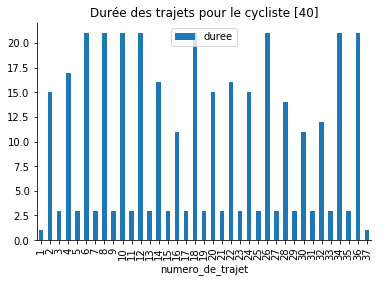

In [43]:
import seaborn as sns
%matplotlib inline
numero_cycliste = [40]
filtre          = df_pandas.id.isin(numero_cycliste)
df_pandas[filtre].plot(kind="bar", x="numero_de_trajet", y="duree", 
                       title="Durée des trajets pour le cycliste %s"%numero_cycliste)
sns.despine()

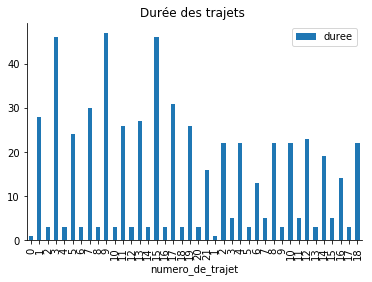

In [44]:

df_pandas.sort_values(["id", "numero_de_trajet"])[:40].plot(kind="bar", x="numero_de_trajet", y="duree", title="Durée des trajets ")
sns.despine()

In [1]:
cyclistes.write.format("csv").save("./../data/cyclistes_a_fin_notebook_2.csv")

NameError: name 'cyclistes' is not defined